In [73]:
import os
import json
import time
import threading
import unicodedata
import collections
import string
import re
import abc
import warnings
import collections
from typing import Optional, Dict, Tuple

import torch #spacy não carrega sem importar antes (??)
import spacy
import tqdm
import groq
from pyserini.search import SimpleSearcher
import sentence_transformers
import bs4
import numpy as np
import matplotlib.pyplot as plt

## Preparação dos dados

In [2]:
if not os.path.isdir("data"):
    os.mkdir("data")

if not os.path.isfile("data\\context_articles.json"):
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/context_articles.tar.gz
    !move context_articles.tar.gz data
    !tar -xf data/context_articles.tar.gz
    !move context_articles.json data

if not os.path.isfile("data\\iirc_test.json"):
    !curl -LO https://iirc-dataset.s3.us-west-2.amazonaws.com/iirc_test.json
    !move iirc_test.json data

In [2]:
file = open("data\\context_articles.json", "r")
articles = json.load(file)
file.close()

In [3]:
file = open("data\\iirc_test.json", "r")
test_data = json.load(file)
file.close()

In [4]:
n_question = 50

@fabiograssiotto: remoção de tags HTML

In [5]:
questions = []
documents_titles = set()
documents = []
documents_not_found = set()

for i in range(len(test_data)):
    item = test_data[i]

    name = item['title'].lower()
    if name not in documents_titles:
        text = item["text"]
        soup = bs4.BeautifulSoup(text, "html.parser")
        clean_text = soup.get_text()

        document = {
                    "title": item['title'],
                    "content": clean_text
                }
        
        documents.append(document)
        documents_titles |= {name}

    for link in item["links"]:
        name : str = link['target'].lower()
        if name in articles and name not in documents_titles:
            text = articles[link['target'].lower()]
            soup = bs4.BeautifulSoup(text, "html.parser")
            clean_text = soup.get_text()
            
            document = {
                "title": link['target'],
                "content": clean_text
            }

            documents.append(document)
            documents_titles |= {name}
        
        else:
            documents_not_found |= {name}

    for q in item["questions"]:
        question = {}
        

        if q["answer"]["type"] == "span":
            question["answer"] = q["answer"]["answer_spans"][0]["text"]
        elif q["answer"]["type"] == "value":
            question["answer"] = q["answer"]["answer_value"]+" "+q["answer"]["answer_unit"]
        elif  q["answer"]["type"] == "none":
            continue
        elif q["answer"]["type"] == "binary":
            question["answer"] = q["answer"]["answer_value"]
        else:
            raise ValueError
        
        question["question"] = q["question"]

        questions.append(question)

        if len(questions) == n_question:
            break
    if len(questions) == n_question:
            break


In [7]:
len(documents_not_found), len(documents)

(17, 419)

In [8]:
nlp = spacy.blank("en")
nlp.add_pipe("sentencizer")

#12345
#   45678
stride = 3#2
max_length = 5#3

def window(documents, stride, max_length):
    treated_documents = []

    for j,document in enumerate(tqdm.tqdm(documents)):
        doc_text = document['content']
        doc = nlp(doc_text[:10000])
        sentences = [sent.text.strip() for sent in doc.sents]
        for i in range(0, len(sentences), stride):
            segment = ' '.join(sentences[i:i + max_length])
            treated_documents.append({
                "title": document['title'],
                "contents": document['title']+". "+segment,
                "segment": segment
            })
            if i + max_length >= len(sentences):
                break
    return treated_documents

treated_documents = window(documents, stride, max_length)

100%|██████████| 419/419 [00:03<00:00, 129.78it/s]


In [9]:
if not os.path.isdir("data\iirc_indices"):
    !mkdir data\iirc_indices

In [10]:
file = open("data/iirc_indices/contents.jsonl",'w')

for i, doc in enumerate(treated_documents):
    doc['id'] = i
    if doc['segment'] != "":
        file.write(json.dumps(doc)+"\n")

In [11]:
!python -m pyserini.index -collection JsonCollection -generator DefaultLuceneDocumentGenerator -threads 1 -input data/iirc_indices -index data/iirc_index -storeRaw

pyserini.index is deprecated, please use pyserini.index.lucene.
2024-05-14 15:05:18,277 INFO  [main] index.IndexCollection (IndexCollection.java:380) - Setting log level to INFO
2024-05-14 15:05:18,280 INFO  [main] index.IndexCollection (IndexCollection.java:383) - Starting indexer...
2024-05-14 15:05:18,280 INFO  [main] index.IndexCollection (IndexCollection.java:384) - ============ Loading Parameters ============
2024-05-14 15:05:18,280 INFO  [main] index.IndexCollection (IndexCollection.java:385) - DocumentCollection path: data/iirc_indices
2024-05-14 15:05:18,280 INFO  [main] index.IndexCollection (IndexCollection.java:386) - CollectionClass: JsonCollection
2024-05-14 15:05:18,281 INFO  [main] index.IndexCollection (IndexCollection.java:387) - Generator: DefaultLuceneDocumentGenerator
2024-05-14 15:05:18,281 INFO  [main] index.IndexCollection (IndexCollection.java:388) - Threads: 1
2024-05-14 15:05:18,281 INFO  [main] index.IndexCollection (IndexCollection.java:389) - Language: en


In [6]:
index_path = "./data/iirc_index"

## Groq API

In [7]:
class GroqInterface:
    '''
    Interface for using the Groq API

    Implements a rate limit control for multi-threading use. 
    '''

    _client :groq.Groq = None 

    LLAMA3_70B = "llama3-70b-8192"

    inference_lock = threading.Lock()
    time_waiter_lock = threading.Lock()
    SINGLE_THREAD = True

    def __init__(self, model:Optional[str]=None, api_key:Optional[str]=None, json_mode:bool=False, system_message:str=None, n_retry:int=5):
        '''
        GroqInterface constructor.

        Args:
            model (str, optional): model to use. Llama3 70B is used if None. Default is None
        '''
        
        if GroqInterface._client is None:

            if api_key is None:
                api_key = os.environ.get("GROQ_API_KEY")

            if api_key is None:
                raise RuntimeError("API key is not in the environment variables ('GROQ_API_KEY' variable is not set).")

            GroqInterface._client = groq.Groq(api_key=api_key)

        if model is None:
            model = GroqInterface.LLAMA3_70B
        self._model = model

        self._system_message = system_message


        if json_mode:
            self._response_format = {"type": "json_object"}
        else:
            self._response_format = None
        self._json_mode = json_mode

        self._n_retry = n_retry

    def __call__(self, prompt:str) -> str:
        '''
        Generates the model response

        Args:
            prompt (str): prompt to send to the model.

        Returns:
            str: model response. 
        '''
        done = False
        retry_count = 0
        while not done:
            try:
                if not GroqInterface.SINGLE_THREAD:
                    GroqInterface.inference_lock.acquire()
                    GroqInterface.inference_lock.release()

                messages = []
                if self._system_message is not None:
                    messages.append({"role":"system", "content":self._system_message})
                
                messages.append({"role":"user", "content":prompt})

                chat_completion = GroqInterface._client.chat.completions.create(
                        messages=messages,
                        model=self._model,
                        response_format=self._response_format
                    )
                
                done = True
            except groq.RateLimitError as exception:
                print("ERROR")
                print(exception)
                
                GroqInterface.error = exception
                if not GroqInterface.SINGLE_THREAD:
                    if not GroqInterface.time_waiter_lock.locked():
                        GroqInterface.time_waiter_lock.acquire()
                        GroqInterface.inference_lock.acquire()
                        time.sleep(2)
                        GroqInterface.time_waiter_lock.release()
                        GroqInterface.inference_lock.release()
                else:
                    time.sleep(2)
            except KeyboardInterrupt as e:
                raise e
                
            except Exception as e:
                retry_count += 1
                if retry_count >= self._n_retry:
                    raise e

        return chat_completion.choices[0].message.content

In [8]:
groq_interface = GroqInterface()

In [15]:
groq_interface("Hi!")

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

## Métrica

In [9]:
class GroqAnswerEvaluator(GroqInterface):

    _system_message = '''You are a answer comparator that outputs in JSON. 
The JSON object must use the schema: {'is_correct':'bool'}
Please use a valid JSON format.'''

    _base_prompt = '''Is the second answer correct, comparing to the first one? 
First answer: {answer_correct}
Second answer: {answer} 
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str]=None):
        super().__init__(model, api_key, True, GroqAnswerEvaluator._system_message)

    def __call__(self, answer_correct:str, answer:str) -> int:

        prompt = GroqAnswerEvaluator._base_prompt.format(answer_correct=answer_correct, answer=answer)

        response = super().__call__(prompt)
        response = json.loads(response)

        return response["is_correct"]

In [10]:
a_gold = "sky and thunder god"
a_correct = "Zeus is known as the king of the gods and the god of the sky and thunder in Greek mythology."
a_wrong = "Zeus is been depicted as using violence to get his way and terrorize humans."

In [11]:
groq_corrector = GroqAnswerEvaluator()

In [19]:
groq_corrector(a_gold, a_correct), groq_corrector(a_gold, a_wrong),

(True, False)

In [12]:
def normalize_answer(s):
  """Lower text and remove punctuation, articles and extra whitespace."""
  def remove_articles(text):
    regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
    return re.sub(regex, ' ', text)
  def white_space_fix(text):
    return ' '.join(text.split())
  def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)
  def lower(text):
    return text.lower()
  def remove_accents(input_str):
      nfkd_form = unicodedata.normalize('NFKD', input_str)
      only_ascii = nfkd_form.encode('ASCII', 'ignore')
      return only_ascii.decode("utf-8")

  return white_space_fix(remove_articles(remove_punc(lower(remove_accents(s)))))

def get_tokens(s):
  if not s: return []
  return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
  return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
  gold_toks = get_tokens(a_gold)
  pred_toks = get_tokens(a_pred)
  common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
  num_same = sum(common.values())
  if len(gold_toks) == 0 or len(pred_toks) == 0:
    # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
    return int(gold_toks == pred_toks)
  if num_same == 0:
    return 0
  precision = 1.0 * num_same / len(pred_toks)
  recall = 1.0 * num_same / len(gold_toks)
  f1 = (2 * precision * recall) / (precision + recall)
  return f1

In [21]:
compute_f1(a_gold, a_correct), compute_exact(a_gold, a_correct)

(0.4, 0)

In [22]:
compute_f1(a_gold, a_wrong), compute_exact(a_gold, a_wrong)

(0.11111111111111112, 0)

## Implementação do ReAct 

### Ferramentas

In [13]:
class Tool(abc.ABC):

    @abc.abstractmethod
    def __call__(self, query:str, context:str):
        ...

In [14]:
class SearchTool(Tool):

    def __init__(self, index_path:str, embedder_model:str="all-MiniLM-L6-v2", search_k:int=20, rerank_k:int=5):
        self.embedder = sentence_transformers.SentenceTransformer(embedder_model)
        self.searcher = SimpleSearcher(index_path)

        if search_k < rerank_k:
            warnings.warn(f"search_k is less than rerank_k. The result will be of search_k size. ({search_k} < {rerank_k})")
        
        self.search_k = search_k
        self.rerank_k = rerank_k
    
    def __call__(self, query:str, context=None) -> Dict[str, str]:
        query_embedding = self.embedder.encode(query, convert_to_tensor=True)

        search_result = self.searcher.search(query, k=self.search_k)
        search_docs = []
        for result in search_result:
            result = json.loads(result.raw)

            search_docs.append(result["segment"])

        search_embeddings = self.embedder.encode(search_docs, convert_to_tensor=True)


        rerank_result = sentence_transformers.util.semantic_search(query_embedding, search_embeddings, top_k=self.rerank_k)

        response = ""
        for result in rerank_result[0]:
            index = result["corpus_id"]
            result_doc = search_docs[index]

            response += result_doc + "\n"
        
        response = {"result":response}


        return response

In [15]:
class AnswerTool(Tool, GroqInterface):
    _system_message = '''You are a question answerer that outputs in JSON. 
The JSON object must use the schema: {'answer':'str'}
Please use a valid JSON format.'''

    _base_prompt = '''{context}

Considering all this context, provide the FINAL ANSWER to the question:
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        super().__init__(model, api_key, True, AnswerTool._system_message)

    def __call__(self, query: Optional[str]=None, context: str=None):
        prompt = AnswerTool._base_prompt.format(context=context)

        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [16]:
class ThinkTool(Tool, GroqInterface):
    _system_message = '''You are responsible for reflecting on provided information, and outputs in JSON. 
The JSON object must use the schema: {'reflection':'str'}
Please use a valid JSON format.'''

    _base_prompt = '''{context}

Considering all this context, provide a useful reflection.
'''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        super().__init__(model, api_key, True, ThinkTool._system_message)

    def __call__(self, query: Optional[str]=None, context: str=None):
        prompt = ThinkTool._base_prompt.format(context=context)

        return json.loads(GroqInterface.__call__(self, prompt=prompt))    

In [17]:
class RoutingTool(Tool, GroqInterface):
    _system_message = '''You are a tool selector that outputs in JSON.
For each selection, you must provide a throught about the previous content and why you are selecting this tool.

You have available the following tools:

Name: 'search'
Query content: the sentence to search
Tool description: it searchs for documents with possible usefull information using the query.

Name: 'answer'
Query content: empty (''), is not used.
Tool description: considering the previous content, provides the final answer for the question.

Name: 'think'
Query content: empty (''), is not used;
Tool descripting: considering the previous content, generates a useful reflection.

The JSON object must use the schema: {'throught':'str',
'tool_name':'str',
'query':'str'}

Please use a valid JSON format.'''

    _base_prompt = '''{context}
    
Considering all this context, select the next tool to use:
    '''

    def __init__(self, model: Optional[str] = None, api_key: Optional[str] = None):
        super().__init__(model, api_key, True, RoutingTool._system_message)

    def __call__(self, query=None, context=None):
        prompt = RoutingTool._base_prompt.format(context=context)

        

        return json.loads(GroqInterface.__call__(self, prompt=prompt))

In [23]:
test_question = "What is Zeus know for in Greek mythology?"

In [18]:
search_tool = SearchTool(index_path)


SimpleSearcher class has been deprecated, please use LuceneSearcher from pyserini.search.lucene instead


In [19]:
answer_tool = AnswerTool()
think_tool = ThinkTool()

routing_tool = RoutingTool()

In [30]:
test_context = f'''Question: {test_question}'''

routing_tool(context=test_context)

{'thought': 'The user has asked a question about Greek mythology, I need to find relevant information.',
 'tool_name': 'search',
 'query': 'What is Zeus known for in Greek mythology?'}

In [31]:
search_result = search_tool("Zeus Greek mythology", "")

In [43]:
print(search_result["result"])

Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion, who rules as king of the gods of Mount Olympus. His name is cognate with the first element of his Roman equivalent Jupiter. His mythologies and powers are similar, though not identical, to those of Indo-European deities such as Jupiter, Perkūnas, Perun, Indra and Thor. Zeus is the child of Cronus and Rhea, the youngest of his siblings to be born, though sometimes reckoned the eldest as the others required disgorging from Cronus's stomach. In most traditions, he is married to Hera, by whom he is usually said to have fathered Ares, Hebe, and Hephaestus.
Since lightning is quite powerful and sometimes deadly, it is a bold sign when lightning strikes because it is known that Zeus most likely threw the bolt. In the Iliad. The Iliad is a poem by Homer about the Trojan war and the battle over the City of Troy, in which Zeus plays a major part. Scenes in which Zeus appears include:



In [32]:
test_context2 = f'''
Question: {test_question}

Thought: I need to search for information about Zeus in Greek mythology to find the answer.
Search result: {search_result["result"]}
'''

routing_tool(context=test_context2)

{'thought': 'Now that I have searched and found information about Zeus in Greek mythology, I can reflect on the key points to understand the essence of his character and significance.',
 'tool_name': 'think',
 'query': ''}

In [33]:
test_context3 = f'''
Question: {test_question}

Thought: I need to search for information about Zeus in Greek mythology to find the answer.
Search result: {search_result["result"]}

Thought: I have gathered information about Zeus in Greek mythology, now I need to think about the context to understand the main points and reflect on the answer.
'''

think_tool(context=test_context3)

{'reflection': "Zeus, in Greek mythology, is the king of the gods, known for being the sky and thunder god, ruling from Mount Olympus. He wields significant power, controlling the weather and fate of humans, often using his lightning bolts to intervene in mortal affairs. Throughout literature, such as in Homer's Iliad, Zeus plays a major role, influencing the war and its outcome. His character is multifaceted, displaying emotions, making decisions, and interacting with other gods and mortals. His power and influence are undeniable, making him a central figure in Greek mythology."}

In [34]:
test_context4 = f'''
Question: {test_question}

Thought: I need to search for information about Zeus in Greek mythology to find the answer.
Search result: {search_result["result"]}

Thought: I have gathered information about Zeus in Greek mythology, now I need to think about the context to understand the main points and reflect on the answer.
Think result: Zeus is known as the sky and thunder god in ancient Greek religion and is often depicted holding a thunderbolt. He is the king of the gods and is married to Hera, with whom he has fathered several children. His powers and mythologies are similar to those of other Indo-European deities, such as Jupiter in Roman mythology. He is often depicted in art standing or seated in majesty, holding a scepter, and is associated with the eagle, bull, and oak."
'''

routing_tool(context=test_context4)

{'thought': 'I have thought about the context and I think it is time to answer the question.',
 'tool_name': 'answer',
 'query': ''}

In [35]:
test_context5 = f'''
Question: {test_question}

Thought: I need to search for information about Zeus in Greek mythology to find the answer.
Search result: {search_result["result"]}

Thought: I have gathered information about Zeus in Greek mythology, now I need to think about the context to understand the main points and reflect on the answer.
Think result: Zeus is known as the sky and thunder god in ancient Greek religion, and is the king of the gods of Mount Olympus.

Thought: "I\'ve reflected on the information and main points about Zeus, now I need to provide a concise answer to the original question."
'''

answer_tool(context=test_context5)

{'answer': 'Zeus is known as the sky and thunder god in ancient Greek religion, and is the king of the gods of Mount Olympus.'}

### Código principal

In [19]:
class QuestionAnswerer:

    def __init__(self, search_tool:SearchTool, routing_tool:RoutingTool=None, think_tool:ThinkTool=None, answer_tool:AnswerTool=None ) -> None:
        self._search_tool = search_tool

        if routing_tool is None:
            routing_tool = RoutingTool()

        if think_tool is None:
            think_tool = ThinkTool()

        if answer_tool is None:
            answer_tool = AnswerTool()

        self._routing_tool = routing_tool
        self._think_tool = think_tool
        self._answer_tool = answer_tool

        
    def __call__(self, question:str, max_steps:int = 5, verbose=False) -> Tuple[str, str, str]:
        context = f"Question: {question}"
        tool_sequence = ""

        step = 0

        while True:
            
            if step >= max_steps-1:
                next_tool = "answer"
                query = ""
                thought = "Now I need to provide a concise answer to the original question."
            else:
                if verbose:
                    print("R", end="")
                tool_sequence += "R"

                rounting_result = self._routing_tool(context=context)
                next_tool = rounting_result["tool_name"].lower()
                query = rounting_result["query"]
                thought = rounting_result["thought"]

            context += f"\n\nThought: {thought}\n"

            if verbose:
                print(next_tool[0].upper(), end="")
            tool_sequence += next_tool[0].upper()

            try:

                if next_tool == "search":
                    search_result = self._search_tool(query=query, context=context)
                    context += f"Search result: {search_result['result']}"
                elif next_tool == "think":
                    think_result = self._think_tool(query=query, context=context)
                    context += f"Think result: {think_result['reflection']}"
                elif next_tool == "answer":
                    answer_result = self._answer_tool(query=query, context=context)

                    print("")
                    return answer_result["answer"], context, tool_sequence
                
            except KeyboardInterrupt as e:
                raise e
            
            except:
                print("F", end="")
                tool_sequence += "F"
                context += "The tool failed. I can try using it again, or try using another tool."
                
            
            step += 1

In [20]:
question_answerer = QuestionAnswerer(search_tool)

In [26]:
answer, context, tool_sequence = question_answerer(test_question, verbose=True)

RSRTRA


In [27]:
answer

"Zeus, in Greek mythology, is the king of the gods and the god of the sky and thunder. He is known for wielding powerful lightning bolts and is depicted in various poses in art, often with his symbols, the thunderbolt, eagle, bull, or oak. He is married to Hera and has fathered several children, including Ares, Hebe, and Hephaestus. Zeus plays a significant role in Homer's Iliad, influencing the outcome of the Trojan War."

In [28]:
print(context)

Question: What is Zeus know for in Greek mythology?

Thought: I want to find relevant information about Zeus in Greek mythology, so I choose a tool that can search for related content.
Search result: Zeus (British English , North American English ; , Zeús ) is the sky and thunder god in ancient Greek religion, who rules as king of the gods of Mount Olympus. His name is cognate with the first element of his Roman equivalent Jupiter. His mythologies and powers are similar, though not identical, to those of Indo-European deities such as Jupiter, Perkūnas, Perun, Indra and Thor. Zeus is the child of Cronus and Rhea, the youngest of his siblings to be born, though sometimes reckoned the eldest as the others required disgorging from Cronus's stomach. In most traditions, he is married to Hera, by whom he is usually said to have fathered Ares, Hebe, and Hephaestus.
Since lightning is quite powerful and sometimes deadly, it is a bold sign when lightning strikes because it is known that Zeus mos

In [29]:
groq_corrector(a_gold, answer), compute_f1(a_gold, answer), compute_exact(a_gold, answer)

(True, 0.1142857142857143, 0)

In [30]:
tool_sequence

'RSRTRA'

## Geração das respostas

In [33]:
all_results = []
file = open ("results.jsonl", "w")

for i in tqdm.tqdm(range(n_question)):
    question = questions[i]["question"]
    gold_answer = questions[i]["answer"]

    try:
        answer, context, tool_sequence = question_answerer(question, verbose=True)

        is_correct = groq_corrector(gold_answer, answer)
        f1_score = compute_f1(gold_answer, answer)
        exact_score = compute_exact(gold_answer, answer)

    except KeyboardInterrupt as e:
        file.close()
        raise e
        
    except:
        answer = ""
        context = ""
        tool_sequence = "F"
        is_correct = False
        f1_score = 0
        exact_score = 0

    entry = {"question_number": i,
            "question":question,
             "gold_answer":gold_answer,
             "answer":answer,
             "tool_sequence":tool_sequence,
             "is_correct":is_correct,
             "f1_score":f1_score,
             "exact_score":exact_score,
             "context":context}
    
    all_results.append(entry)

    file.write(json.dumps(entry)+"\n")
    file.flush()

file.close()

  0%|          | 0/50 [00:00<?, ?it/s]

RSRTRA


  2%|▏         | 1/50 [00:35<28:57, 35.47s/it]

RSRTRA


  4%|▍         | 2/50 [01:21<33:15, 41.57s/it]

RSRA


  6%|▌         | 3/50 [01:44<25:50, 33.00s/it]

RSRTRA


  8%|▊         | 4/50 [02:28<28:53, 37.68s/it]

RSRTRA


 10%|█         | 5/50 [03:23<32:43, 43.63s/it]

RSRSRA


 12%|█▏        | 6/50 [04:08<32:25, 44.21s/it]

RSRA


 14%|█▍        | 7/50 [04:22<24:39, 34.41s/it]

RSRTRA


 16%|█▌        | 8/50 [05:25<30:24, 43.43s/it]

RSRSRA


 18%|█▊        | 9/50 [06:06<29:14, 42.80s/it]

RSRA


 20%|██        | 10/50 [06:24<23:21, 35.03s/it]

RSRA


 22%|██▏       | 11/50 [06:56<22:09, 34.10s/it]

RSRA


 24%|██▍       | 12/50 [07:14<18:34, 29.32s/it]

RSRTRA


 26%|██▌       | 13/50 [07:50<19:16, 31.25s/it]

RSRTRA


 28%|██▊       | 14/50 [08:34<21:01, 35.04s/it]

RSRA


 30%|███       | 15/50 [08:49<16:56, 29.05s/it]

RSRTRSRA


 32%|███▏      | 16/50 [10:08<25:00, 44.13s/it]

RSRTRSRA


 34%|███▍      | 17/50 [11:37<31:39, 57.57s/it]

RSRTRSR

 36%|███▌      | 18/50 [15:04<54:43, 102.61s/it]

ERROR
RSRTRA


 38%|███▊      | 19/50 [15:34<41:36, 80.53s/it] 

RSRTRA


 40%|████      | 20/50 [17:26<45:01, 90.04s/it]

RSRTRA


 42%|████▏     | 21/50 [18:38<40:54, 84.63s/it]

RSRTRA


 44%|████▍     | 22/50 [20:07<40:06, 85.96s/it]

RSRTRA


 46%|████▌     | 23/50 [21:15<36:17, 80.66s/it]

RSRA


 48%|████▊     | 24/50 [22:00<30:21, 70.06s/it]

RSRTRA


 50%|█████     | 25/50 [24:07<36:13, 86.94s/it]

RSRTRA


 52%|█████▏    | 26/50 [26:38<42:27, 106.14s/it]

RSRTRSRTA


 54%|█████▍    | 27/50 [29:37<49:06, 128.10s/it]

RSRTRSRSA


 56%|█████▌    | 28/50 [31:56<48:11, 131.45s/it]

RSRTRA


 58%|█████▊    | 29/50 [32:13<33:58, 97.05s/it] 

RSRTRA


 60%|██████    | 30/50 [32:59<27:16, 81.81s/it]

RSRA


 62%|██████▏   | 31/50 [33:25<20:31, 64.81s/it]

RSRTRA


 64%|██████▍   | 32/50 [34:10<17:44, 59.16s/it]

RSRTRA


 66%|██████▌   | 33/50 [35:01<16:04, 56.71s/it]

RSRTRA


 68%|██████▊   | 34/50 [35:43<13:52, 52.00s/it]

RSRA


 70%|███████   | 35/50 [35:55<10:04, 40.28s/it]

RSRTRSRA


 72%|███████▏  | 36/50 [37:41<13:59, 59.97s/it]

RSRA


 74%|███████▍  | 37/50 [38:05<10:39, 49.21s/it]

RSRTRA


 76%|███████▌  | 38/50 [39:01<10:13, 51.12s/it]

RSRTRA


 78%|███████▊  | 39/50 [39:42<08:49, 48.17s/it]

RSRA


 80%|████████  | 40/50 [40:04<06:41, 40.16s/it]

RSRA


 82%|████████▏ | 41/50 [40:28<05:17, 35.27s/it]

RSRA


 84%|████████▍ | 42/50 [40:51<04:14, 31.80s/it]

RSRTRA


 86%|████████▌ | 43/50 [41:22<03:41, 31.61s/it]

RSRA


 88%|████████▊ | 44/50 [41:43<02:50, 28.39s/it]

RSRTRSRTA


 90%|█████████ | 45/50 [43:32<04:22, 52.57s/it]

RSRA


 92%|█████████▏| 46/50 [43:54<02:52, 43.24s/it]

RSRA


 94%|█████████▍| 47/50 [44:15<01:50, 36.74s/it]

RSRTRA


 96%|█████████▌| 48/50 [44:51<01:13, 36.53s/it]

RSRTRA


 98%|█████████▊| 49/50 [45:30<00:37, 37.27s/it]

RSRTRA


100%|██████████| 50/50 [46:07<00:00, 55.35s/it]


46 min 7,5s

In [60]:
file = open("results.json", "w")
json.dump(all_results, file)
file.close()

## Avaliação

In [53]:
accuracy = 0.0
f1_scores = np.empty(n_question)
exact_scores = np.empty(n_question)
tool_sequences = []

for i in range(n_question):
    accuracy += all_results[i]["is_correct"]
    f1_scores[i] = all_results[i]["f1_score"]
    exact_scores[i] = all_results[i]["exact_score"]
    tool_sequences.append(all_results[i]["tool_sequence"])

accuracy /= n_question

print("Accuracy:", accuracy)
print("F1 score:", f1_scores.mean(), "±", f1_scores.std())
print("Exact score:", exact_scores.mean(), "±", exact_scores.std())

Accuracy: 0.52
F1 score: 0.47502661713188027 ± 0.45167093813665027
Exact score: 0.36 ± 0.48


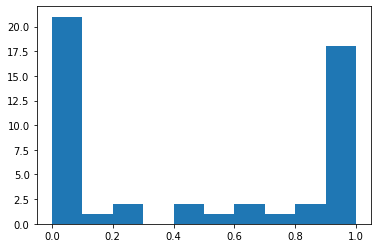

In [50]:
plt.hist(f1_scores)
plt.show()

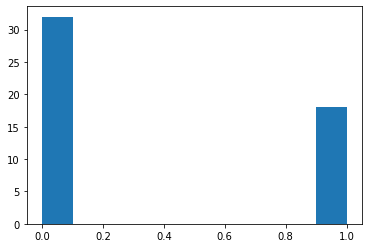

In [52]:
plt.hist(exact_scores)
plt.show()

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

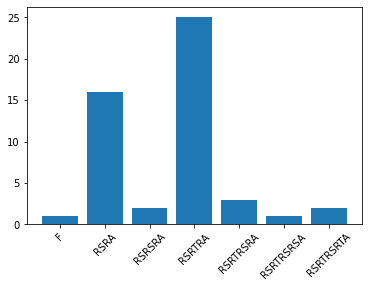

In [58]:
tool_sequences_unique, tool_sequences_count = np.unique(tool_sequences, return_counts=True)

plt.bar(tool_sequences_unique, tool_sequences_count)
plt.xticks(rotation=45)

In [105]:
node_queue = collections.deque()
node_queue.append("")

adj_list = {}

while len(node_queue) != 0:
    current_node = node_queue.pop()

    if current_node in adj_list:
        continue

    adj = []

    total_occurrences = 0
    n_sequence = 0
    sequences = {}
    for i in range(len(tool_sequences_unique)):
        sequence = tool_sequences_unique[i]
        occurrences = tool_sequences_count[i]
        
        if len(sequence) > len(current_node):
            if sequence[:len(current_node)] != current_node:
                continue
            
            total_occurrences += occurrences

            next_char = sequence[len(current_node)]

            if next_char in sequences:
                sequences[next_char] += occurrences
                
            else:
                sequences[next_char] = occurrences

                if current_node+next_char not in node_queue:
                    node_queue.append(current_node+next_char)

    

    for sequence in sequences:
        sequences[sequence] /= total_occurrences
    adj_list[current_node] = sequences
        


In [123]:
print("flowchart LR")

for node in adj_list:
    for next_char in adj_list[node]:
        node_to_print = node

        if node_to_print == "":
            node_to_print = "''"

        probability = adj_list[node][next_char]
        probability *= 100
        probability = round(probability, 2)

        if int(probability) == probability:
            probability = int(probability)

        next_node = node+next_char
        print(f"{node_to_print} -->|{next_char} {probability}%| {next_node}")

flowchart LR
'' -->|F 2%| F
'' -->|R 98%| R
R -->|S 100%| RS
RS -->|R 100%| RSR
RSR -->|A 32.65%| RSRA
RSR -->|S 4.08%| RSRS
RSR -->|T 63.27%| RSRT
RSRT -->|R 100%| RSRTR
RSRTR -->|A 80.65%| RSRTRA
RSRTR -->|S 19.35%| RSRTRS
RSRTRS -->|R 100%| RSRTRSR
RSRTRSR -->|A 50%| RSRTRSRA
RSRTRSR -->|S 16.67%| RSRTRSRS
RSRTRSR -->|T 33.33%| RSRTRSRT
RSRTRSRT -->|A 100%| RSRTRSRTA
RSRTRSRS -->|A 100%| RSRTRSRSA
RSRS -->|R 100%| RSRSR
RSRSR -->|A 100%| RSRSRA


Renderizando o diagrama em [Mermaid Live Editor](https://mermaid.live/):

[Disponível online](https://mermaid.ink/img/pako:eNptkkFrgzAYhv_KR2D00gZnVms9DITR03bxyzGXoOkqqzqyyBht__tSo0ldd0ue5-P9XkhOpOwqRTKyP3bf5UFqA6-FaBcLWK2ezzuIH86w8_cCtqkFdqAY7giPUXQFaAmOIxO6TqGby4HFNFk7nAeO8ESj1GEMmEPCaLxxnA-c_w3nLp5PC9LIL-DjCu5LbinzDkeH94k4Zfra6xuXz6WNTWiyCR7nngNjlLHgufd8TJ-t5iEf__Po_F3tsbSvfCNysiSN0o2sK_vCJ9ECCGIOqlGCZPZYSf0hiGgvdk72psOftiSZ0b1akv6zkka91PJdy4Zke3n8slRVten0m_syw8-5_AJB36Zj?type=png)

[![](https://mermaid.ink/img/pako:eNptkkFrgzAYhv_KR2D00gZnVms9DITR03bxyzGXoOkqqzqyyBht__tSo0ldd0ue5-P9XkhOpOwqRTKyP3bf5UFqA6-FaBcLWK2ezzuIH86w8_cCtqkFdqAY7giPUXQFaAmOIxO6TqGby4HFNFk7nAeO8ESj1GEMmEPCaLxxnA-c_w3nLp5PC9LIL-DjCu5LbinzDkeH94k4Zfra6xuXz6WNTWiyCR7nngNjlLHgufd8TJ-t5iEf__Po_F3tsbSvfCNysiSN0o2sK_vCJ9ECCGIOqlGCZPZYSf0hiGgvdk72psOftiSZ0b1akv6zkka91PJdy4Zke3n8slRVten0m_syw8-5_AJB36Zj?type=png)](https://mermaid.live/edit#pako:eNptkkFrgzAYhv_KR2D00gZnVms9DITR03bxyzGXoOkqqzqyyBht__tSo0ldd0ue5-P9XkhOpOwqRTKyP3bf5UFqA6-FaBcLWK2ezzuIH86w8_cCtqkFdqAY7giPUXQFaAmOIxO6TqGby4HFNFk7nAeO8ESj1GEMmEPCaLxxnA-c_w3nLp5PC9LIL-DjCu5LbinzDkeH94k4Zfra6xuXz6WNTWiyCR7nngNjlLHgufd8TJ-t5iEf__Po_F3tsbSvfCNysiSN0o2sK_vCJ9ECCGIOqlGCZPZYSf0hiGgvdk72psOftiSZ0b1akv6zkka91PJdy4Zke3n8slRVten0m_syw8-5_AJB36Zj)